# Preset filters

In this exercise, we will try to improve the model performance by giving the model additional features as input.
Here, we will use rather simple convolutional features and use them as input to the MLP model from the previous
exercise.

## Preparation

In [2]:
# load tensorboard extension
%load_ext tensorboard

In [3]:
# import torch and other libraries
import os
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from tqdm import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

In [4]:
!pip install cifar2png

  Using cached cifar2png-0.0.4.tar.gz (5.8 kB)
  Using cached pathlib-1.0.1.tar.gz (49 kB)
  Created wheel for cifar2png: filename=cifar2png-0.0.4-py3-none-any.whl size=5931 sha256=bed2d5e5eb67f0443d7f7054d0fc4abe2782385792d542a995c6208db27cc012
  Stored in directory: /g/kreshuk/pape/.cache/pip/wheels/f5/8f/07/c1d632c47b80ecbed8f6866edfa21fd9ca21c72f9ccb8216e9
  Created wheel for pathlib: filename=pathlib-1.0.1-py3-none-any.whl size=14346 sha256=7b2d7a3a33f3754befbd48364b9d94c0b6ac989bea1819462867337a3c495ac3
  Stored in directory: /g/kreshuk/pape/.cache/pip/wheels/6e/96/b8/10037fe231e23970bac58361d7c93571ab983a7bbc55e68550
Successfully built cifar2png pathlib


In [5]:
# check if we have gpu support
# colab offers free gpus, however they are not activated by default.
# to activate the gpu, go to 'Runtime->Change runtime type'. 
# Then select 'GPU' in 'Hardware accelerator' and click 'Save'
have_gpu = torch.cuda.is_available()
# we need to define the device for torch, yadda yadda
if have_gpu:
    print("GPU is available")
    device = torch.device('cuda')
else:
    print("GPU is not available, training will run on the CPU")
    device = torch.device('cpu')

GPU is available


In [6]:
# run this in google colab to get the utils.py file
!wget https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py 

--2020-10-07 20:23:38--  https://raw.githubusercontent.com/constantinpape/training-deep-learning-models-for-vison/master/day1/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14228 (14K) [text/plain]
Saving to: ‘utils.py.1’

100%[======================================>] 14.228      --.-K/s   in 0,001s  

2020-10-07 20:23:38 (25,2 MB/s) - ‘utils.py.1’ saved [14228/14228]



In [7]:
# we will reuse the training function, validation function and
# data preparation from the previous notebook
import utils

In [8]:
cifar_dir = './cifar10'
!cifar2png cifar10 cifar10

cifar-10-python.tar.gz does not exists.
167kKB [00:06, 24.1kKB/s]                                                       
Saving test images: 100%|████████████████| 10000/10000 [00:32<00:00, 308.32it/s]


In [9]:
categories = os.listdir('./cifar10/train')
categories.sort()

In [100]:
images, labels = utils.load_cifar('./cifar10/train')
train_images, train_labels, val_images, val_labels = utils.make_cifar_train_val_split(images, labels)

100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


In [45]:
test_images, test_labels = utils.load_cifar('./cifar10/test')

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


## Filters

We will now ...

In [104]:
# apply a list of filters as on the fly transformation. 
def apply_filters(image, target, filter_list, keep_image=False):    
    filtered = [image] if keep_image else [] 
    for filter_function in filter_list:
        filtered.append(filter_function(image))
    data = np.concatenate(filtered, axis=-1)
    return data, target

In [105]:
# build dataset with filter transformations
from functools import partial
import skimage.filters as sk_filters

filters = [sk_filters.gaussian, sk_filters.laplace]
filters = partial(apply_filters, filter_list=filters,
                  keep_image=True)

trafos = [
    utils.normalize,
    filters,
    utils.to_channel_first,
    utils.to_tensor
]
trafos = partial(utils.compose, transforms=trafos)

train_dataset = utils.DatasetWithTransform(train_images, train_labels,
                                           transform=trafos)
val_dataset = utils.DatasetWithTransform(val_images, val_labels,
                                         transform=trafos)

/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


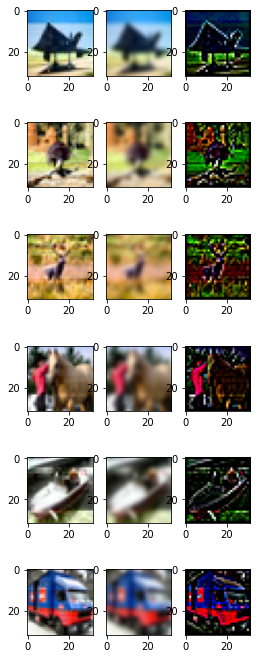

In [106]:
# visualize the filters
import matplotlib.pyplot as plt
n_images = 6
image_ids = np.arange(len(train_dataset))
np.random.shuffle(image_ids)
image_ids = image_ids[:n_images]

fig, ax = plt.subplots(n_images, 3, figsize=(4, 12))
for ii, im_id in enumerate(image_ids):
    im, _ = train_dataset[im_id]
    ax[ii, 0].imshow(im[0:3].numpy().transpose((1, 2, 0)))
    ax[ii, 1].imshow(im[3:6].numpy().transpose((1, 2, 0)))
    ax[ii, 2].imshow(im[6:9].numpy().transpose((1, 2, 0)))

In [53]:
# make loaders for training and validation data
batch_size = 8
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, 
                          shuffle=True,
                          num_workers=8)

val_loader = DataLoader(val_dataset, batch_size=10)

In [54]:
# this is the initial MLP from the previous exercise
from utils import SimpleMLP

In [55]:
# instantiate the model
# note: we have more input features now;
# for each filter 3 additional channels are added to the model
n_filters = 3
n_input_channels = n_filters * 3 * 32 * 32
model = SimpleMLP(n_input_channels, 10)
model = model.to(device)

In [56]:
%tensorboard --logdir runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
Traceback (most recent call last):
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/bin/tensorboard", line 10, in <module>
    sys.exit(run_main())
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/tensorboard/main.py", line 65, in run_main
    default.get_plugins(),
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/tensorboard/default.py", line 113, in get_plugins
    return get_static_plugins() + get_dynamic_plugins()
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/tensorboard/default.py", line 151, in get_dynamic_plugins
    "tensorboard_plugins"
  File "/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/tensorboard/default.py", line 150, in <listcomp>
    for entry_point in

In [57]:
optimizer = Adam(model.parameters(), lr=1.e-4)
loss_function = nn.NLLLoss()
loss_function.to(device)

# you can find the results of this training run in the tensorboard
# above as well, they will have the name 'log_reg_filters1' and
# will be differently colored compared to the first model
tb_logger = SummaryWriter('runs/log_reg_filters1')

n_epochs = 4
for epoch in trange(n_epochs):
    utils.train(model, train_loader, loss_function, optimizer,
                device, epoch, tb_logger=tb_logger, log_image_interval=None)
    step = (epoch + 1) * len(train_loader)
    utils.validate(model, val_loader, loss_function, device, step,
                   tb_logger=tb_logger)

  0%|          | 0/4 [00:00<?, ?it/s]/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """
/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: Run

/home/pape/Work/software/conda/miniconda3/envs/torch14/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  """


Test accuracy
0.4154



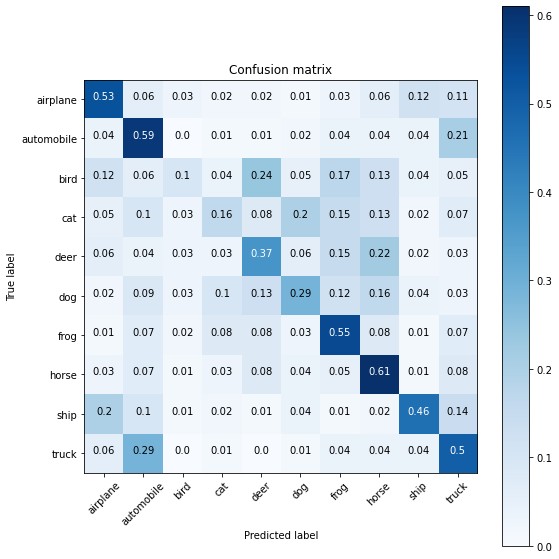

In [58]:
# evaluate the new model
test_dataset = utils.DatasetWithTransform(test_images, test_labels,
                                          transform=trafos)
test_loader = DataLoader(test_dataset, batch_size=25)

test_predictions, test_labels = utils.validate(model, test_loader, loss_function,
                                               device, 0, tb_logger=None)
accuracy = metrics.accuracy_score(test_labels, test_predictions)
print("Test accuracy")
print(accuracy)
print()

fig, ax = plt.subplots(1, figsize=(8, 8))
utils.make_confusion_matrix(test_labels,
                            test_predictions,
                            categories, ax)

## Expressing convolutional filters in pytorch

In [ ]:
# compute kernel size for gaussian with sigma = 1
kernel = np.zeros((7, 7), dtype='float32')
# TODO set the proper gaussian kernel

c = nn.Conv2d(3, 3, 7, padding=3)
with torch.no_grad():
    c[:, :] = kernel

## Tasks and Questions

Tasks
- Express laplacian as nn.Conv2d

Advanced
- Replace the filters in dataset by putting them into the network